In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline


In [414]:
def cal_ks(label,score):
    fpr,tpr,thresholds= roc_curve(label,score)
    return max(tpr-fpr)
    
def cal_auc_ks(y_true, y_pred, name = None, save=False):
    sample = name + " Sample : %s" % len(y_true)
    auc = name + ' test_set auc : %0.3f' % roc_auc_score(y_true, y_pred)
    ks = name + ' test_set ks  : %0.3f' % cal_ks(y_true,y_pred) 
    print (sample)
    print (auc)
    print (ks)
    print ('----------------cal_auc_ks process successfully!----------------')
    if save:
        if name:
            pass
        else:
            name = ''
        with open(name + '_auc&ks.txt', 'a+') as f:
            f.write(sample + '\n' + auc + '\n' + ks + '\n' + '------------------------------------' + '\n' )
            print ('----------------cal_auc_ks save successfully!----------------')
    return roc_auc_score(y_true, y_pred), cal_ks(y_true,y_pred) 

In [415]:
def dimensions_of_data(file_name):
    max_dimension = -1
    min_dimension = 1e6
    with open(file_name, 'r') as f:    
        lines = f.readlines()
        for line in lines[1:2]:
            data, label = line.split('\t')
            
            for pair in data.split(' '):
                index = int(pair.split(':')[0])
                max_dimension = max(index, max_dimension)
                min_dimension = min(index, min_dimension)
                
    return max_dimension, min_dimension
    

In [416]:
train_dims, train_min_dims = dimensions_of_data('train.data')
test_dims, test_min_dims = dimensions_of_data('test.data')
dims = max(train_dims, test_dims)

In [417]:
def read_data(file_name, dims):
    
    with open(file_name, 'r') as f:    
        lines = f.readlines()        
        
        rows, cols = len(lines) - 1, dims + 2
        all_data = np.array([[np.nan for _ in range(cols)] for _ in range(rows)])

        for idx, line in enumerate(lines[1:]):
            data, label = line.split('\t')
            
            all_data[idx, -1] = float(label)
            
            for pair in data.split(' '):
                index = int(pair.split(':')[0])
                val = pair.split(':')[1]
                
                all_data[idx, index] = val
    
    return pd.DataFrame(all_data)

In [418]:
train = read_data('train.data', dims)
test = read_data('test.data', dims)
feature_importance = pd.read_csv('feature_importance_lgb.txt', header=-1)

In [419]:
feature_importance_threshold = 50

feature_importance_index = feature_importance[feature_importance.iloc[:, 1] > feature_importance_threshold].iloc[:, 0]

def feature_select(data, idx):
    
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    y_name = data.columns[-1]
    
    X = X[idx]
    X[y_name] = y

    return X

train = feature_select(train, feature_importance_index)
test = feature_select(test, feature_importance_index)



In [434]:
train.head()

,2725,1048,2724,2728,2806,2730,2737,1588,1419,2787,...,1730,1250,1655,2206,2600,2053,1076,1253,998,2840
0,-1.0,1.58489,-1.00000,1.14470,0.0,0.55302,3.03143,0.978182,1.00000,0.0,...,4.612988,1.58489,6.74879,4.716260,0.941032,0.0000,4.10577,5.87516,1.321829,1.0
1,-1.0,1.28474,-1.00000,0.96253,0.0,0.58850,2.50176,1.148700,1.14870,1.0,...,4.573050,1.47577,4.84388,6.669466,0.000000,2.3685,3.98107,4.21684,1.350960,1.0
2,0.0,1.20112,5.44866,0.00000,0.0,0.00000,2.75946,0.978182,1.00000,1.0,...,3.430060,1.31951,5.50383,6.669466,1.148700,2.3685,5.50383,4.79136,1.321829,1.0
3,-1.0,1.14870,-1.00000,0.96253,0.0,0.47131,2.56947,0.978182,1.00000,0.0,...,4.612988,1.14870,5.69679,6.669466,0.941032,2.3685,5.69679,4.95934,1.321829,1.0
4,-1.0,1.35096,-1.00000,0.00000,0.0,0.40221,2.61807,0.978182,0.87055,1.0,...,4.216840,1.55185,6.22311,6.669466,1.148700,2.3685,4.57305,5.41753,1.321829,0.0


/Users/zhengcao/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


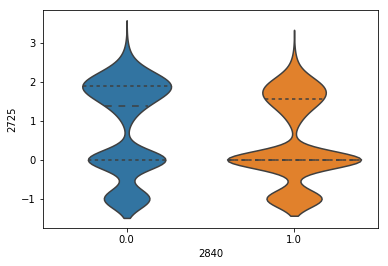

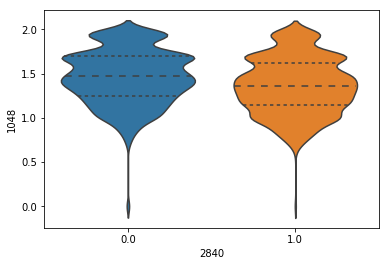

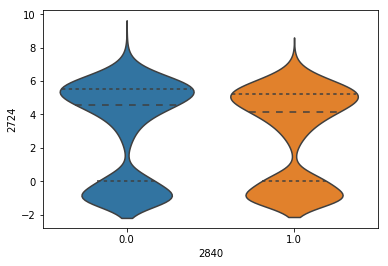

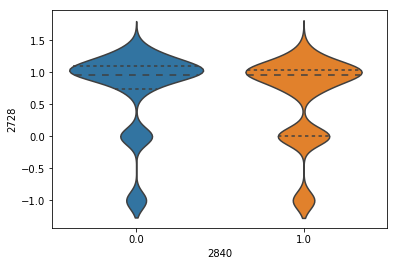

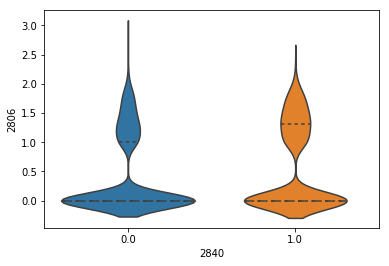

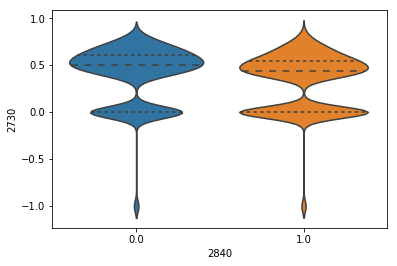

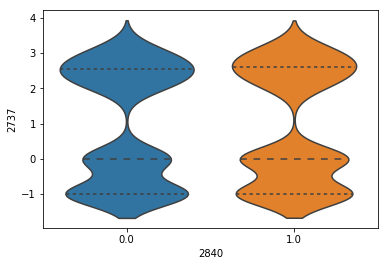

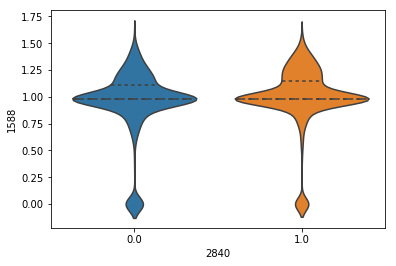

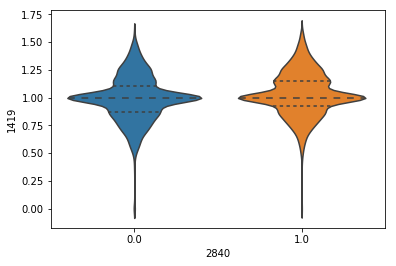

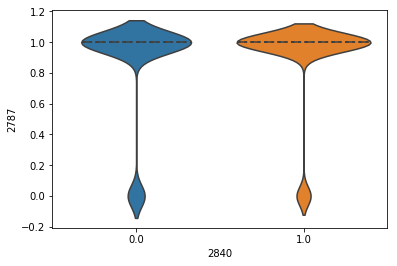

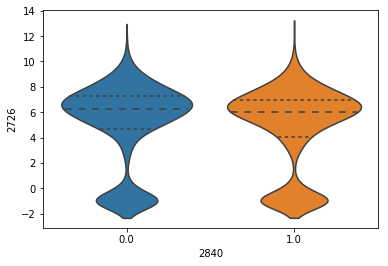

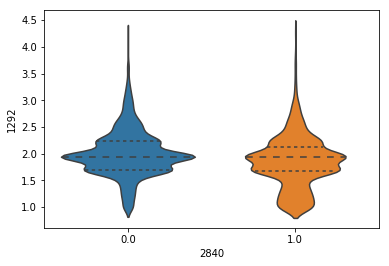

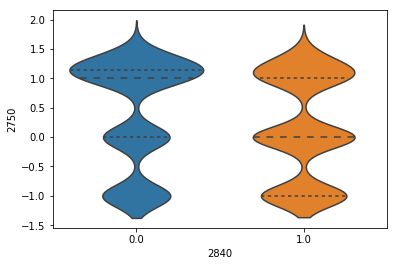

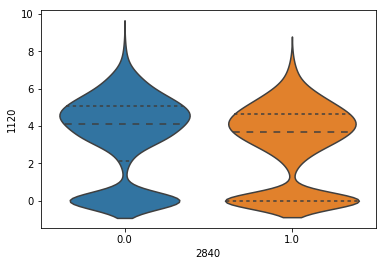

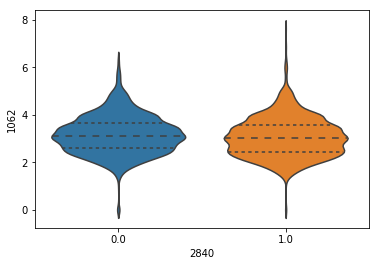

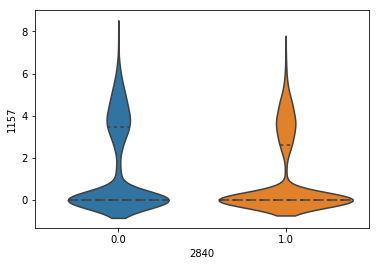

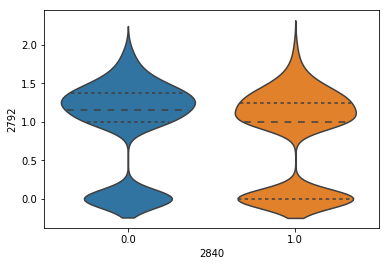

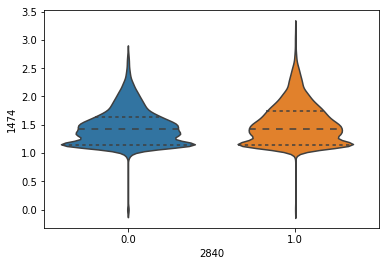

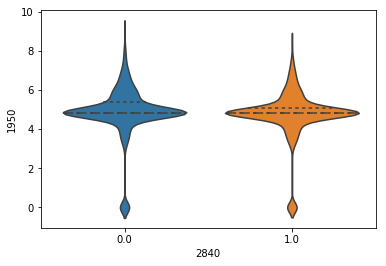

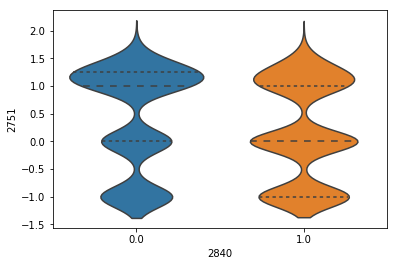

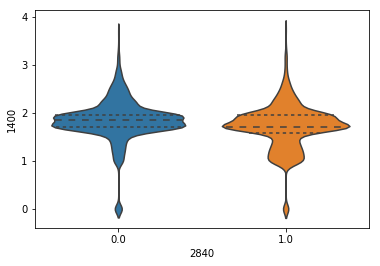

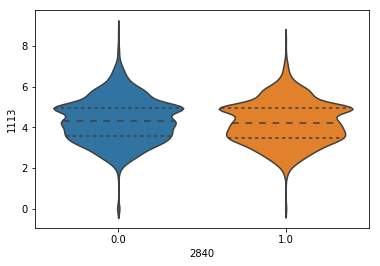

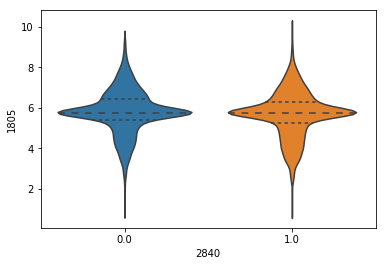

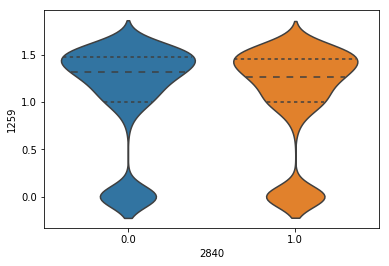

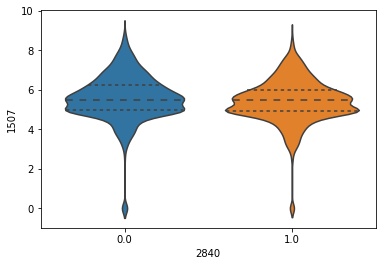

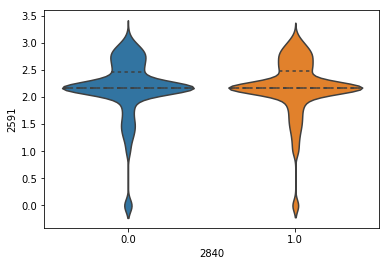

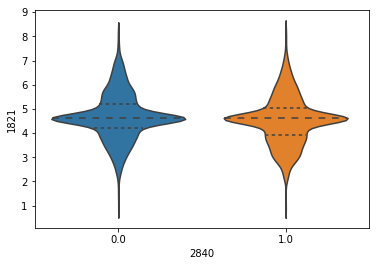

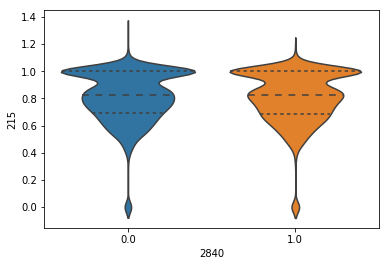

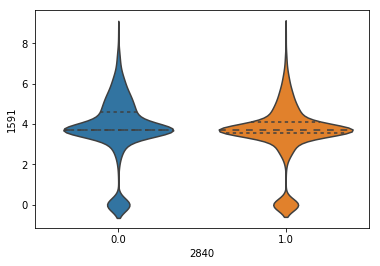

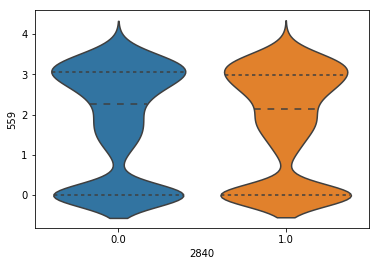

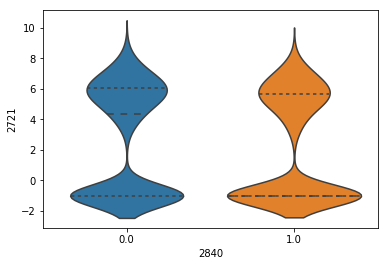

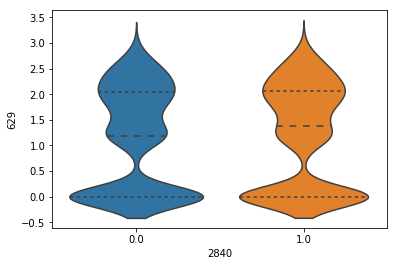

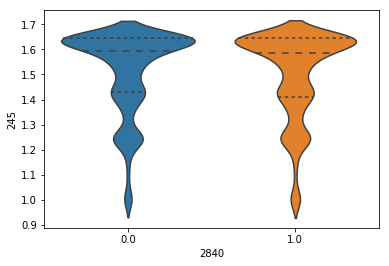

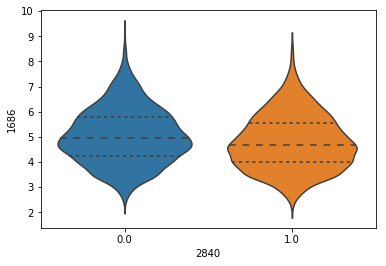

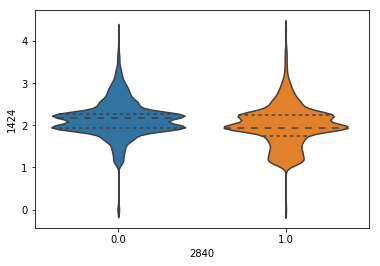

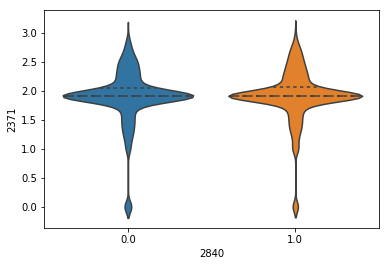

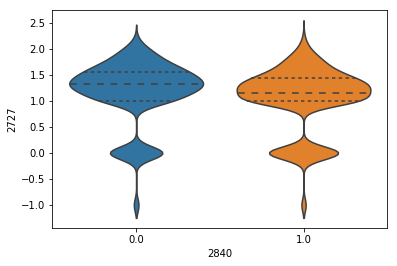

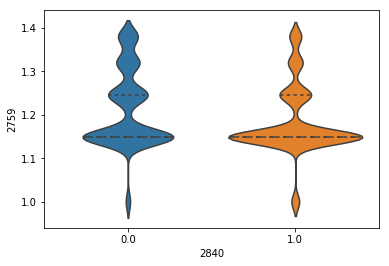

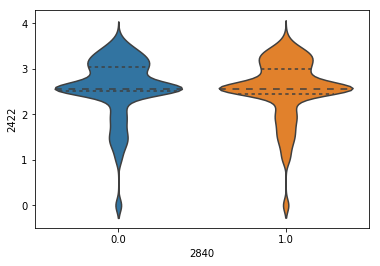

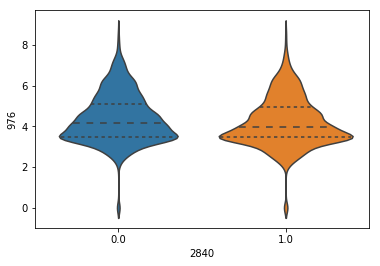

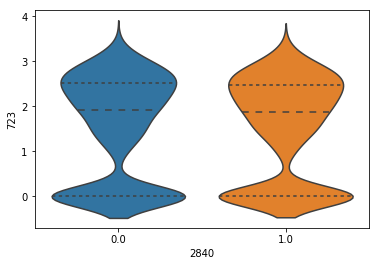

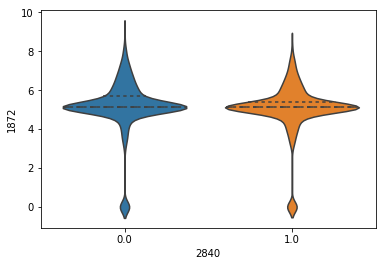

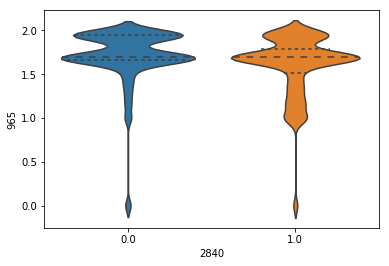

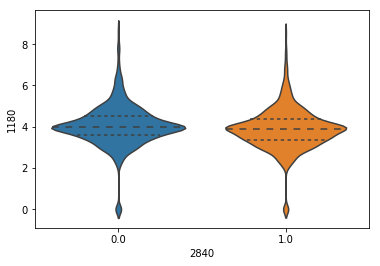

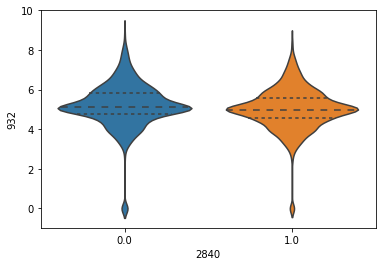

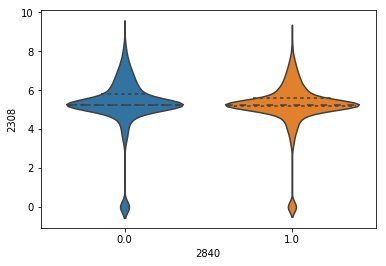

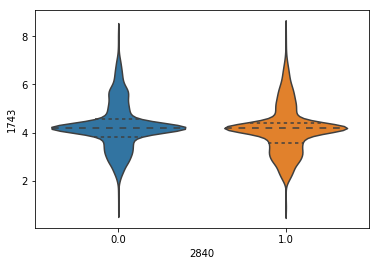

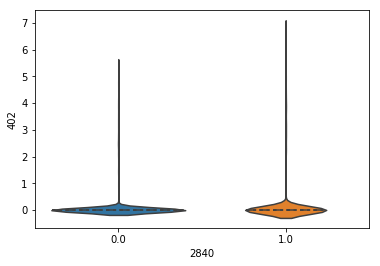

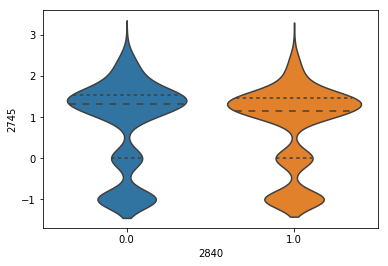

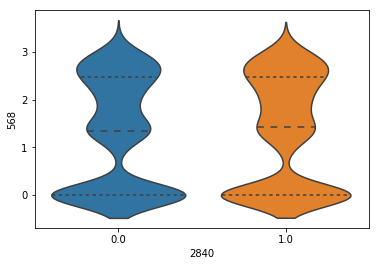

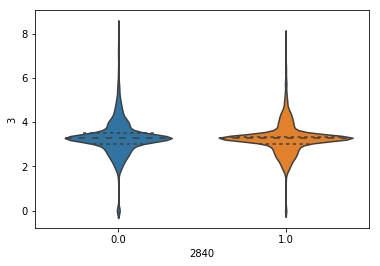

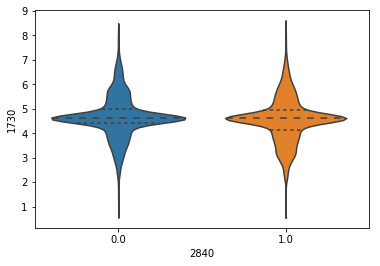

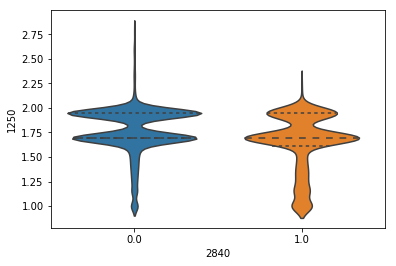

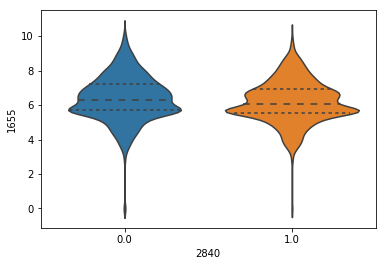

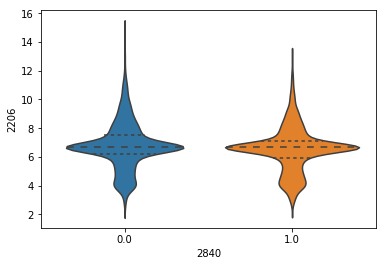

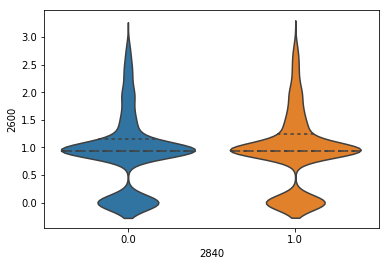

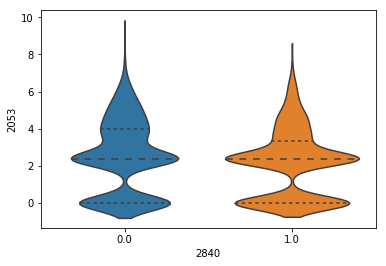

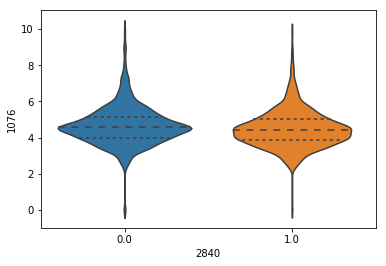

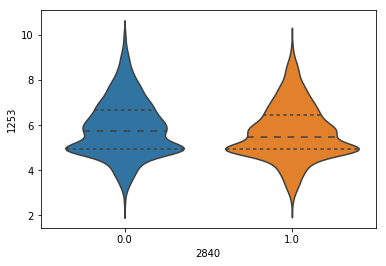

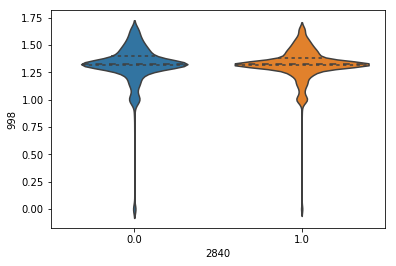

In [471]:
fig_size = (6, 8)
n_figures = train.shape[1] -1
# # n_figures = 2
# _, axis = plt.subplots(n_figures, figsize = fig_size)
# for i, ax in zip(range(n_figures), axis):
#     plot = sns.violinplot(x=2840, y=train.columns[i], data=train, ax=ax, inner='quartile')
#     plot.get_figure().savefig('./violinplots/variable' + str(train.columns[i]) + ".jpg")
# # plt.show()

for i in range(n_figures):
    plt.figure()
    plot = sns.violinplot(x=2840, y=train.columns[i], data=train, inner='quartile')
    plot.get_figure().savefig('./violinplots/variable' + str(train.columns[i]) + ".jpg")
# plt.show()

In [421]:
train_train_X, train_validation_X, train_train_y, train_validation_y = train_test_split(train.iloc[:, :-1], train.iloc[:, -1],test_size=0.3, random_state=4000, stratify=train.iloc[:, -1])

# cv_res = lgb.cv(param, train_ds, verbose_eval=True, shuffle=True)

In [422]:
# train_ds = lgb.Dataset(data=train_train_X, label=train_train_y)
# train_validation_ds = lgb.Dataset(data=train_validation_X, label=train_validation_y)

# param = {'num_leaves': 31,
#          'min_data_in_leaf': 30, 
#          'objective':'binary',
#          'max_depth': -1,
#          'learning_rate': 0.01,
#          "min_child_samples": 20,
#          "boosting": "gbdt",
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
# #          "metric": 'binary_logloss',
#          "metric": 'binary_error',
#          "lambda_l1": 0.1,
#          "verbosity": -1,
#          "nthread": 4,
#          "random_state": 4590}


# clf = lgb.train(param, train_ds, num_boost_round=1000, verbose_eval=True, valid_sets=train_validation_ds, early_stopping_rounds=500)
# test_prob = clf.predict(test.iloc[:, :-1])

# def prop_to_label(data, threshold):
#     return np.array([1 if val > threshold else 0 for val in data])


# threshold = 0.5
# test_label = prop_to_label(test_prob, threshold)

# cal_auc_ks(test.iloc[:, -1].values.tolist(), test_label.tolist(), name='results')
# print('confusion matrix', confusion_matrix(test.iloc[:, -1].values.tolist(), test_label.tolist()))
# print('f1', f1_score(test.iloc[:, -1].values.tolist(), test_label.tolist()))

In [423]:
train.head()


,2725,1048,2724,2728,2806,2730,2737,1588,1419,2787,...,1730,1250,1655,2206,2600,2053,1076,1253,998,2840
0,-1.0,1.58489,-1.00000,1.14470,0.0,0.55302,3.03143,NaN,1.00000,0.0,...,NaN,1.58489,6.74879,4.71626,NaN,0.0,4.10577,5.87516,NaN,1.0
1,-1.0,1.28474,-1.00000,0.96253,0.0,0.58850,2.50176,1.1487,1.14870,1.0,...,4.57305,1.47577,4.84388,NaN,0.0000,NaN,3.98107,4.21684,1.35096,1.0
2,0.0,1.20112,5.44866,0.00000,0.0,0.00000,2.75946,NaN,1.00000,1.0,...,3.43006,1.31951,5.50383,NaN,1.1487,NaN,5.50383,4.79136,NaN,1.0
3,-1.0,1.14870,-1.00000,0.96253,0.0,0.47131,2.56947,NaN,1.00000,0.0,...,NaN,1.14870,5.69679,NaN,NaN,NaN,5.69679,4.95934,NaN,1.0
4,-1.0,1.35096,-1.00000,0.00000,0.0,0.40221,2.61807,NaN,0.87055,1.0,...,4.21684,1.55185,6.22311,NaN,1.1487,NaN,4.57305,5.41753,NaN,0.0


In [424]:
uniq_counts = np.array([train.iloc[:, c].unique().shape[0] for c in range(train.shape[1])])
categorical_cols = train.columns[uniq_counts < 10]
numerical_cols = train.columns[uniq_counts >= 10]


for cat_col in categorical_cols:
    mode = train[cat_col].mode()[0]
    train[cat_col].fillna(mode, inplace=True)
    test[cat_col].fillna(mode, inplace=True)
    
for num_col in numerical_cols:
    mean = train[num_col].mean()
    train[num_col].fillna(mean, inplace=True)    
    test[num_col].fillna(mean, inplace=True)        
    
categorical_cols, numerical_cols



(Int64Index([2787, 2759, 2840], dtype='int64'),
 Int64Index([2725, 1048, 2724, 2728, 2806, 2730, 2737, 1588, 1419, 2726, 1292,
             2750, 1120, 1062, 1157, 2792, 1474, 1950, 2751, 1400, 1113, 1805,
             1259, 1507, 2591, 1821,  215, 1591,  559, 2721,  629,  245, 1686,
             1424, 2371, 2727, 2422,  976,  723, 1872,  965, 1180,  932, 2308,
             1743,  402, 2745,  568,    3, 1730, 1250, 1655, 2206, 2600, 2053,
             1076, 1253,  998],
            dtype='int64'))

In [425]:
params = [{"C": np.logspace(-2, 1, 5), 'degree': [2, 3, 4]}]
# params = [{"C": [0.01], }]
svc = SVC(gamma='auto', kernel='poly')

train_X = train.iloc[:, :-1]
train_y = train.iloc[:, -1].astype('int')
# train_y = train.iloc[:, -1]
# print(train_y)

test_X = test.iloc[:, :-1]
test_y = test.iloc[:, -1].astype('int')

grid = GridSearchCV(svc, cv=5, param_grid=params, scoring='f1')
grid.fit(train_X, train_y)

print('best parameter', grid.best_params_)
# print('train f1: ', np.mean(cross_val_score(grid.best_estimator_, train_X, train_y, cv=5, scoring='f1')))
# print('test f1: ', np.mean(cross_val_score(grid.best_estimator_, test_X, test_y, cv=5, scoring='f1')))

predictions = grid.best_estimator_.predict(test_X)

cal_auc_ks(predictions, test_y, name='results')
print('confusion matrix:', confusion_matrix(predictions, test_y))
print('f1 score:', f1_score(predictions, test_y))

best parameter {'C': 0.01, 'degree': 2}
results Sample : 2999
results test_set auc : 0.626
results test_set ks  : 0.252
----------------cal_auc_ks process successfully!----------------
confusion matrix: [[1244  557]
 [ 526  672]]
f1 score: 0.553770086526576


In [426]:
# params = [{"C": np.logspace(-2, 1, 5), "penalty": ['l1', 'l2']}]
# clf = LogisticRegression()

# train_X = train.iloc[:, :-1]
# train_y = train.iloc[:, -1].astype('int')
# # train_y = train.iloc[:, -1]
# # print(train_y)

# test_X = test.iloc[:, :-1]
# test_y = test.iloc[:, -1].astype('int')

# grid = GridSearchCV(clf, cv=5, param_grid=params, scoring='f1')
# grid.fit(train_X, train_y)

# print('best parameter', grid.best_params_)
# print('train f1: ', np.mean(cross_val_score(grid.best_estimator_, train_X, train_y, cv=5, scoring='f1')))

# predictions = grid.best_estimator_.predict(test_X)

# cal_auc_ks(predictions, test_y, name='results')
# print('confusion matrix:', confusion_matrix(predictions, test_y))
# print('f1 score:', f1_score(predictions, test_y))